In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("..")

os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['MUJOCO_GL']='egl'

%load_ext autoreload
%autoreload 2

from envs.maze_envs import CustomPointUMazeSize3Env, CustomAntUMazeSize3Env
source_env = CustomPointUMazeSize3Env()
target_env = CustomAntUMazeSize3Env()

source_env.reset(42, None)
target_env.reset(42, None)

(array([ 0.05479121, -0.01222431,  0.8217196 ,  0.99160886, -0.07742714,
         0.09074426,  0.049823  ,  0.05721286, -0.07437728, -0.00992281,
        -0.0258404 ,  0.08535299,  0.02877302,  0.06455232, -0.01131716,
         1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,
         1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,
         1.3140707 ,  1.3140707 ,  1.3140707 ,  1.3140707 ,  0.        ],
       dtype=float32),
 None)

In [2]:
print(source_env.observation_space.shape)
print(target_env.observation_space.shape)

(7,)
(30,)


In [3]:
## Source PointUMaze; Target AntUMaze
from datasets.dataset import Dataset

expert_source = np.load("../outputs/2024-04-04/21-13-01/saved_expert/trained_expert.npy", allow_pickle=True).item()
random_source = np.load("../outputs/2024-04-04/21-13-01/saved_prior/random_policy.npy", allow_pickle=True).item()
random_target = np.load("../outputs/2024-04-04/21-43-22/saved_prior/random_policy.npy", allow_pickle=True).item()

expert_source_ds = Dataset(observations=expert_source['observations'],
                           actions=expert_source['actions'],
                           rewards=expert_source['rewards'],
                           dones_float=expert_source['dones'],
                           masks=1.0 - expert_source['dones'],
                           next_observations=expert_source['next_observations'],
                           size=expert_source['observations'].shape[0])

non_expert_source_ds = Dataset(observations=random_source['observations'],
                           actions=random_source['actions'],
                           rewards=random_source['rewards'],
                           dones_float=random_source['dones'],
                           masks=1.0 - random_source['dones'],
                           next_observations=random_source['next_observations'],
                           size=random_source['observations'].shape[0])

agent_target_ds = Dataset(observations=random_target['observations'],
                           actions=random_target['actions'],
                           rewards=random_target['rewards'],
                           dones_float=random_target['dones'],
                           masks=1.0 - random_target['dones'],
                           next_observations=random_target['next_observations'],
                           size=random_target['observations'].shape[0])

(-0.5, 479.5, 479.5, -0.5)

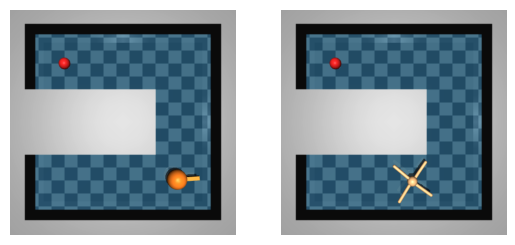

In [4]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
source_env.wrapped_env.set_xy(expert_source['observations'][30, :2])
target_env.wrapped_env.set_xy(random_target['observations'][500, :2])
axs[0].imshow(source_env.render('rgb_array'))
axs[1].imshow(target_env.render('rgb_array'))

axs[0].axis('off')
axs[1].axis('off')

In [5]:
from ott.neural.solvers.neuraldual import W2NeuralDual
import jax.numpy as jnp
import jax
from ott.geometry import costs
from ott.problems.linear import potentials

class W2NeuralDualCustom(W2NeuralDual):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.back_and_forth = True
        self.step = 0
    
    def update(self, batch_agent, batch_expert):

        update_forward = not self.back_and_forth or self.step % 2 == 0
        train_batch = {}

        if update_forward:
            train_batch["source"] = batch_agent
            train_batch["target"] = batch_expert
            (self.state_f, self.state_g, loss, loss_f, loss_g, w_dist) = self.train_step_parallel(
                self.state_f,
                self.state_g,
                train_batch,
            )
        else:
            train_batch["target"] = batch_agent
            train_batch["source"] = batch_expert
            (self.state_g, self.state_f, loss, loss_f, loss_g, w_dist) = self.train_step_parallel(
                self.state_g,
                self.state_f,
                train_batch,
            )

        self.step += 1
       
        return self, loss, w_dist

In [24]:
import jax
from networks.common import MLP, Model, LayerNormMLP, TrainState
import jax.numpy as jnp
import optax
import flax.linen as nn
from flax.struct import PyTreeNode
from typing import Sequence, Dict
from ott.neural.solvers.neuraldual import W2NeuralDual
from ott.neural import models
import functools
import flax


class Encoders(nn.Module):
    encoders: Dict[str, nn.Module]
    
    def encode_expert(self, expert_states):
        return self.encoders['expert_encoder'](expert_states)
    
    def encode_agent(self, agent_states):
        return self.encoders['agent_encoder'](agent_states)
    
    def __call__(self, agent_obs, expert_obs):
        rets = {
            "encoded_agent": self.encode_agent(agent_obs),
            "encoded_expert": self.encode_expert(expert_obs)
        }
        return rets

class JointAgent:

    def __init__(
        self,
        encoder_agent: nn.Module,
        encoder_expert: nn.Module,
        agent_dim: int,
        expert_dim: int,
        embed_dim: int,
        neural_f: nn.Module,
        neural_g: nn.Module,
        optimizer_f,
        optimizer_g,
        expert_loss_coef: float = 0.5,
        learning_rate: float = 1e-4,
        rng = jax.random.PRNGKey(42)) -> None:

        self.expert_loss_coef = expert_loss_coef

        encoders = Encoders({
            'agent_encoder': encoder_agent,
            'expert_encoder': encoder_expert
        })

        self.encoders_state = TrainState.create(
            model_def=encoders,
            params=encoders.init(rng, jnp.ones(agent_dim), jnp.ones(expert_dim))['params'],
            tx=optax.adam(learning_rate=learning_rate)
        )

        self.neural_dual_elements = W2NeuralDualCustom(
            dim_data=embed_dim, 
            neural_f=neural_f,
            neural_g=neural_g,
            optimizer_f=optimizer_f,
            optimizer_g=optimizer_g,
            num_train_iters=20000
        )

        self.neural_dual_pairs = W2NeuralDualCustom(
            dim_data=embed_dim * 2, 
            neural_f=neural_f,
            neural_g=neural_g,
            optimizer_f=optimizer_f,
            optimizer_g=optimizer_g,
            num_train_iters=20000
        )

    @staticmethod
    def ot_distance_elements(learned_potentials, x, y):
        return learned_potentials.distance(x, y)
    
    @staticmethod
    def ot_distance_pairs(learned_potentials, x, y, x_next, y_next):
        x_pair = jnp.concatenate([x, x_next], axis=-1)
        y_pair = jnp.concatenate([y, y_next], axis=-1)

        return learned_potentials.distance(x_pair, y_pair)
    
    @staticmethod
    def compute_expert_encoder_loss(learned_potentials, y, y_next): # maximize target potential g w.r.t encoder
        y_pair = jnp.concatenate([y, y_next], axis=-1)
        g_value = jax.vmap(learned_potentials.g)(y_pair)
        return jnp.mean((y_pair ** 2).sum(-1)) - 2 * jnp.mean(g_value)
    
    @staticmethod
    def encoders_loss(potentials_elem, potentials_pairs, sa, se, sn, sa_next, se_next, sn_next, expert_loss_coef):
        
        loss_elem = JointAgent.ot_distance_elements(
            potentials_elem, 
            jnp.concatenate([sa, sa], axis=0), 
            jnp.concatenate([se, sn], axis=0), 
        )
        loss_pairs = JointAgent.ot_distance_pairs(potentials_pairs, sn, se, sn_next, se_next)
        # expert_enc_loss = JointAgent.compute_expert_encoder_loss(potentials_pairs, y, y_next)
        
        loss = loss_elem - loss_pairs * expert_loss_coef

        return loss, loss_elem, loss_pairs
        
    def optimize_not(self, batch_agent, batch_expert, random_data):
        
        @jax.jit
        def compute_embeds(encoders, batch_agent, batch_expert, random_data):
            se = encoders(batch_expert.observations, method='encode_expert')
            se_next = encoders(batch_expert.next_observations, method='encode_expert')
            sn = encoders(random_data.observations, method='encode_expert')
            sn_next = encoders(random_data.next_observations, method='encode_expert')
            sa = encoders(batch_agent.observations, method='encode_agent')
            sa_next = encoders(batch_agent.next_observations, method='encode_agent')

            sa_pairs = jnp.concatenate([sa, sa_next], axis=-1)
            se_pairs = jnp.concatenate([se, se_next], axis=-1)
            sn_pairs = jnp.concatenate([sn, sn_next], axis=-1)

            return  sa, se, sn, sa_pairs, se_pairs, sn_pairs
        
        sa, se, sn, sa_pairs, se_pairs, sn_pairs = compute_embeds(self.encoders_state, batch_agent, batch_expert, random_data)

        _, loss_elem, w_dist_elem = self.neural_dual_elements.update(np.concatenate([sa, sa]), np.concatenate([se, sn]))
        _, loss_pairs, w_dist_pairs = self.neural_dual_pairs.update(np.concatenate([sa_pairs, sn_pairs]), np.concatenate([se_pairs, se_pairs]))
        
        return loss_elem, loss_pairs, w_dist_elem, w_dist_pairs
    
    def optimize_encoders(self, batch_agent, batch_expert, random_data):

        @jax.jit
        def update_step(potentials_elem, potentials_pairs, encoders, batch_agent, batch_expert, random_data):

            def loss_fn(params):

                se = encoders(batch_expert.observations, params=params, method='encode_expert')
                se_next = encoders(batch_expert.next_observations, params=params, method='encode_expert')
                sa = encoders(batch_agent.observations, params=params, method='encode_agent')
                sa_next = encoders(batch_agent.next_observations, params=params, method='encode_agent')
                sn = encoders(random_data.observations, method='encode_expert')
                sn_next = encoders(random_data.next_observations, method='encode_expert')

                loss, not_loss, expert_enc_loss = JointAgent.encoders_loss(potentials_elem, potentials_pairs, sa, se, sn, sa_next, se_next, sn_next, self.expert_loss_coef)

                return loss, {'loss': loss,
                            'not_distance': not_loss,
                            'expert_encoder_loss': expert_enc_loss}
            
            new_encoders, info = encoders.apply_loss_fn(loss_fn=loss_fn, has_aux=True)

            return new_encoders, info
        
        potentials_elem = self.neural_dual_elements.to_dual_potentials()
        potentials_pairs = self.neural_dual_pairs.to_dual_potentials()

        self.encoders_state, info = update_step(
            potentials_elem, potentials_pairs, self.encoders_state, batch_agent, batch_expert, random_data
        )
        
        return info

In [25]:
rng = jax.random.PRNGKey(42)

enc1_key, enc2_key = jax.random.split(rng, 2)

hidden_dims = [32, 16, 8, 2]
encoder_expert = LayerNormMLP(hidden_dims=hidden_dims)
encoder_agent = LayerNormMLP(hidden_dims=hidden_dims)

# encoder_expert = MLP(hidden_dims=hidden_dims)
# encoder_agent = MLP(hidden_dims=hidden_dims)


neural_f = models.MLP(
    dim_hidden=[32, 32, 32, 32],
    is_potential=True,
)
neural_g = models.MLP(
    dim_hidden=[32, 32, 32, 32],
    is_potential=True,
)
# lr_schedule = optax.cosine_decay_schedule(
#     init_value=1e-4, decay_steps=5, alpha=1e-2
# )
optimizer_f = optax.adam(learning_rate=3e-4, b1=0.9, b2=0.99)
optimizer_g = optimizer_f

agent = JointAgent(
    encoder_agent, 
    encoder_expert, 
    target_env.observation_space.shape[0], 
    source_env.observation_space.shape[0],
    hidden_dims[-1],
    neural_f,
    neural_g,
    optimizer_f,
    optimizer_g)

In [26]:
from ott.tools import sinkhorn_divergence
from ott.geometry import pointcloud

@jax.jit
def sinkhorn_loss(
    x: jnp.ndarray, y: jnp.ndarray, epsilon: float = 0.001
) -> float:
    """Computes transport between (x, a) and (y, b) via Sinkhorn algorithm."""
    a = jnp.ones(len(x)) / len(x)
    b = jnp.ones(len(y)) / len(y)

    sdiv = sinkhorn_divergence.sinkhorn_divergence(
        pointcloud.PointCloud, x, y, epsilon=epsilon, a=a, b=b
    )
    return sdiv.divergence


In [27]:
from tqdm import tqdm

for i in tqdm(range(500)):
    agent_data = agent_target_ds.sample(512)
    expert_data = expert_source_ds.sample(512)
    random_data = non_expert_source_ds.sample(512)
    loss_elem, loss_pairs, w_dist_elem, w_dist_pairs = agent.optimize_not(agent_data, expert_data, random_data)

    if i % 100 == 0:
        se = agent.encoders_state(expert_data.observations, method='encode_expert')
        sa = agent.encoders_state(agent_data.observations, method='encode_agent')
        sink = sinkhorn_loss(sa, se)
        print(loss_elem, loss_pairs, w_dist_elem, w_dist_pairs, sink)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:05<46:05,  5.54s/it]

4.1812005 8.770513 0.08723831 -0.042253494 1.7256359


  7%|▋         | 36/500 [00:24<05:19,  1.45it/s]


KeyboardInterrupt: 

In [23]:
for i in range(1000):
    agent_data = agent_target_ds.sample(512)
    expert_data = expert_source_ds.sample(512)
    random_data = non_expert_source_ds.sample(512)
    loss_elem, loss_pairs, w_dist_elem, w_dist_pairs = agent.optimize_not(agent_data, expert_data, random_data)
    if i % 5 == 0:
        info = agent.optimize_encoders(agent_data, expert_data, random_data)
    if i % 50 == 0:
        print(info)
        se = agent.encoders_state(expert_data.observations, method='encode_expert')
        sa = agent.encoders_state(agent_data.observations, method='encode_agent')
        sink = sinkhorn_loss(sa, se)
        print(loss_elem, loss_pairs, w_dist_elem, w_dist_pairs, sink)
        print()

{'expert_encoder_loss': Array(-0.02095413, dtype=float32), 'loss': Array(0.13872194, dtype=float32), 'not_distance': Array(0.12824488, dtype=float32)}
4.455649 9.093426 0.107584 -0.06304932 1.9404536

{'expert_encoder_loss': Array(0.28732014, dtype=float32), 'loss': Array(0.3725729, dtype=float32), 'not_distance': Array(0.51623297, dtype=float32)}
3.930334 8.568418 0.50802803 0.34858513 1.580107



KeyboardInterrupt: 